<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/style_transfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

import os
import cv2
%matplotlib inline
from tqdm import tqdm

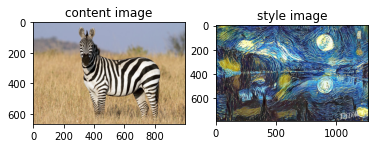

In [7]:
project_path = '/content/drive/My Drive/hairy_gan'
content_img_path = os.path.join(project_path, 'content.jpg')
style_img_path = os.path.join(project_path, 'style.jpg')
content_img = plt.imread(content_img_path)
style_img = plt.imread(style_img_path)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(content_img)
axes[0].set_title('content image')

axes[1].imshow(style_img)
axes[1].set_title('style image')

plt.show()

In [12]:
def load_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (400, 400))
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [13]:
content_img = load_image(content_img_path)
style_img = load_image(style_img_path)

content_img.shape, style_img.shape

(TensorShape([400, 400, 3]), TensorShape([400, 400, 3]))

In [14]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 0s 0us/step


In [15]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
content_layers = ['block4_conv2']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [18]:
def mini_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model(inputs=[vgg.input], outputs=outputs)
  return model

In [19]:
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  height, width, channels = temp.shape
  fun = tf.reshape(temp, [channels, height * width])
  result = tf.matmul(temp, temp, transpose_a=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [20]:
class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg = mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(self.style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0

    inputs = preprocess_input(inputs)

    outputs = self.vgg(inputs)

    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = { content_name: value for content_name, value in zip(self.content_layers, content_outputs) }
    style_dict = { style_name: value for style_name, value in zip(self.style_layers, style_outputs) }

    return { 'content': content_dict, 'style': style_dict }


In [23]:
content_img = load_image(content_img_path)
content_img = np.expand_dims(content_img, axis=0)
style_img = load_image(style_img_path)
style_img = np.expand_dims(style_img, axis=0)

In [24]:
model = StyleModel(style_layers, content_layers)
style_targets = model(style_img)['style']
content_targets = model(content_img)['content']

In [26]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [28]:
style_weight = 100
content_weight = 10

style_weights = { 
    'block1_conv1': 1., 
    'block2_conv1': 0.8,
    'block3_conv1': 0.5,
    'block4_conv1': 0.3,
    'block5_conv1': 0.1
}

In [37]:
def get_style_loss(outputs):
  loss = tf.add_n([style_weights[name] * tf.reduce_mean((val - style_targets[name])**2) for name, val in outputs.items()])
  loss *= style_weight / num_style_layers
  return loss

def get_content_loss(outputs):
  loss = tf.add_n([tf.reduce_mean((val - content_targets[name])**2) for name, val in outputs.items()])
  loss *= content_weight / num_content_layers
  return loss

def total_loss(outputs):
  style_loss = get_style_loss(outputs['style'])
  content_loss = get_content_loss(outputs['content'])
  loss = style_loss + content_loss
  return loss, style_loss, content_loss


In [41]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape: # auto calculates gradinets
    outputs = model(image)
    loss, _, _ = total_loss(outputs)

  grad = tape.gradient(loss, image)

  opt.apply_gradients([(grad, image)]) # wait.. we are applying the gradient to the image not the model..???

  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)) # clip pixels to be in range of [0, 1]

In [39]:
target_img = tf.Variable(content_img)

Train 0 / 10: 100%|██████████| 100/100 [07:48<00:00,  4.68s/it]


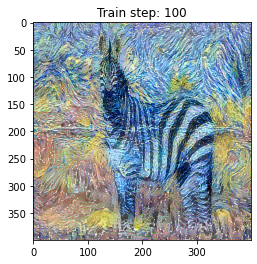

Train 1 / 10: 100%|██████████| 100/100 [07:47<00:00,  4.68s/it]


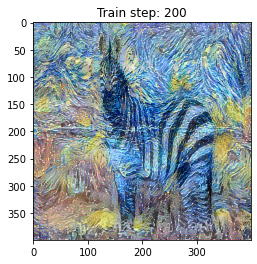

Train 2 / 10: 100%|██████████| 100/100 [07:47<00:00,  4.68s/it]


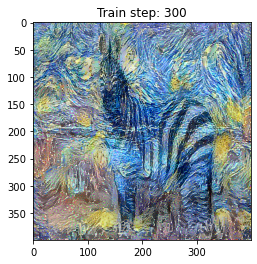

Train 3 / 10: 100%|██████████| 100/100 [07:46<00:00,  4.67s/it]


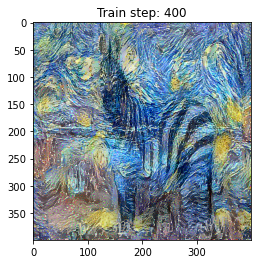

Train 4 / 10: 100%|██████████| 100/100 [07:46<00:00,  4.67s/it]


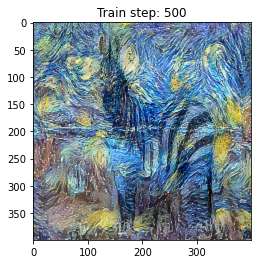

Train 5 / 10: 100%|██████████| 100/100 [07:46<00:00,  4.67s/it]


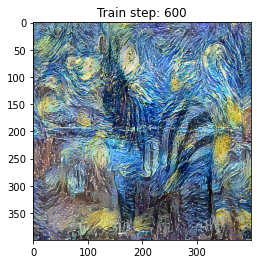

Train 6 / 10: 100%|██████████| 100/100 [07:47<00:00,  4.67s/it]


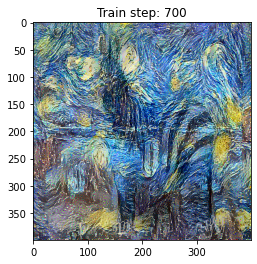

Train 7 / 10:  86%|████████▌ | 86/100 [06:41<01:05,  4.67s/it]

KeyboardInterrupt: ignored

In [48]:
epochs = 10
steps_per_epoch = 100

step = 0
for epoch in range(epochs):
  for step_i in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
    step += 1
    train_step(target_img)
  
  plt.imshow(np.squeeze(target_img.read_value(), 0))
  plt.title('Train step: {}'.format(step))
  plt.show()